##exploratory data analysis

In [ ]:
!pip install pygam catboost
!pip install lightgbm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score, KFold , train_test_split
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

 importing data processed from our first notebook 'notebook1'

In [ ]:
#original test dataset
test_url='https://raw.githubusercontent.com/ousama-88/prohack_dataset_fIZoqt7/ousama-88-patch-1/test.csv'
dft = pd.read_csv(test_url)
eei = dft[['galactic year', 'galaxy', 'existence expectancy index']]

#loading 'data' from the first notebook / 'data' is our data processed from the first notebook 
data_url='https://raw.githubusercontent.com/ousama-88/prohack_dataset_fIZoqt7/ousama-88-patch-1/dft_medium.csv'
data=pd.read_csv(data_url)
dft=data
print(data.shape)
data.head()

(4754, 72)


,galactic year,galaxy,existence expectancy index,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),"Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),Employment in services (% of total employment),Employment to population ratio (% ages 15 and older),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Maternal mortality ratio (deaths per 100,000 live births)",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),Population with at least some secondary education (% ages 25 and older),"Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),Gender Development Index (GDI),Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Gender Inequality Index (GII),total dependency ratio calc,Gross galactic product (GGP) per capita calc,HDI,Life expectancy index,Expected years of education ratio,Population with secondary education ratio,Intergalactic Development Index ratio,Estimated gross galactic income per capita ratio,"Intergalactic Development Index ratio, Rank",Labour force participation rate (% ages 15 and older) ratio,Life expectancy at birth ratio,Mortality rate ratio,Expected to mean ratio,Tourists per citizen,Estimated gross galactic income per capita mean,Expected years of education (galactic years) mean,Intergalactic Development Index (IDI) mean,"Intergalactic Development Index (IDI) mean, Rank",Labour force participation rate (% ages 15 and older) mean,Mean years of education (galactic years) mean,Mortality rate mean,Population with at least some secondary education mean,Private galaxy capital flows (% of GGP) per capita,break_year,y
0,1007012,KK98 77,0.737356,10.139146,0.779650,13.960975,8.887087,0.728130,0.670940,171.977659,3.654192,4.343763,69.772498,4.764147,4.189151,2.733861,69.606299,74.693484,82.151451,4.684415,76.390962,2.662199,64.137669,75.285328,62.442473,70.047597,53.926922,2.167933,3.351950,3.454970,2.903432,10.250033,131.906023,26.700256,2.516501,6.283879,81.007427,4.678478,85.301271,337.693765,111.491061,49.175097,8.910713,1.009299,21.611898,5.945708,0.665018,1.084490,8.572520,0.765435,0.768548,0.990936,1.155729,1.065057,1.061552,1.029841,1.259997,0.936735,1.038244,1.520186,0.117899,10.151602,14.561799,0.806248,138.861675,76.787827,9.845762,5.817069,79.188302,0.028175,0,NaN
1,1007012,Reticulum III,0.712058,9.926427,0.636253,11.875058,7.217977,0.621502,0.575842,194.718616,3.869156,4.444387,63.290926,4.981939,4.329670,2.711365,69.597667,73.670608,85.922500,4.829555,87.450316,2.579952,67.318379,75.757198,59.518971

In [ ]:
isNull = list(eei[eei['existence expectancy index'].isnull()].index)
isNull

[885, 886, 887, 888, 889]

In [ ]:
eei.loc[isNull, 'existence expectancy index'] = \
dft.loc[isNull, 'existence expectancy index']
df_galaxy = dft['galaxy'].value_counts()
galaxys = list(df_galaxy.index)

In [ ]:
dft['y'] = np.exp(dft['y'])

In [ ]:
iskl = ['galaxy', 'y']
iskl

['galaxy', 'y']

expolring train data / test data 

In [ ]:
df = dft.loc[~dft['y'].isnull(), :]
t_df = dft.loc[dft['y'].isnull(), :]
df #train dataset

,galactic year,galaxy,existence expectancy index,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),"Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),Employment in services (% of total employment),Employment to population ratio (% ages 15 and older),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Maternal mortality ratio (deaths per 100,000 live births)",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),Population with at least some secondary education (% ages 25 and older),"Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),Gender Development Index (GDI),Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Gender Inequality Index (GII),total dependency ratio calc,Gross galactic product (GGP) per capita calc,HDI,Life expectancy index,Expected years of education ratio,Population with secondary education ratio,Intergalactic Development Index ratio,Estimated gross galactic income per capita ratio,"Intergalactic Development Index ratio, Rank",Labour force participation rate (% ages 15 and older) ratio,Life expectancy at birth ratio,Mortality rate ratio,Expected to mean ratio,Tourists per citizen,Estimated gross galactic income per capita mean,Expected years of education (galactic years) mean,Intergalactic Development Index (IDI) mean,"Intergalactic Development Index (IDI) mean, Rank",Labour force participation rate (% ages 15 and older) mean,Mean years of education (galactic years) mean,Mortality rate mean,Population with at least some secondary education mean,Private galaxy capital flows (% of GGP) per capita,break_year,y
890,990025,Large Magellanic Cloud (LMC),0.802746,10.040310,0.735036,13.726439,7.691231,0.731595,0.660039,166.349277,3.396769,4.223143,63.225889,4.730072,4.168411,2.789708,75.444862,79.190468,74.977743,4.624447,79.913389,2.486172,65.748537,73.741790,61.026563,71.217997,50.947042,2.222581,3.218036,3.308361,2.840182,10.156216,128.753623,26.106626,2.526466,6.282385,107.477582,4.676949,73.036507,334.874139,106.090078,52.325053,8.147719,0.993895,23.087389,5.314261,0.644981,1.136694,8.327224,0.754825,0.803818,0.994683,1.171186,1.066787,1.064519,1.009266,1.398077,0.935230,1.038842,1.733409,0.123105,10.113571,14.490081,0.798586,130.720209,77.804309,9.351103,5.715018,72.063473,0.030490,0,0.052590
891,990025,Camelopardalis B,0.937576,10.160740,0.869755,15.395466,9.894746,0.831921,0.746288,141.982621,3.250847,3.893165,79.940697,4.586597,3.962858,2.842118,78.646289,83.120525,69.728002,4.461087,64.190571,2.580

In [ ]:
dft #test dataset

,galactic year,galaxy,existence expectancy index,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),"Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),Employment in services (% of total employment),Employment to population ratio (% ages 15 and older),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Maternal mortality ratio (deaths per 100,000 live births)",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),Population with at least some secondary education (% ages 25 and older),"Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),Gender Development Index (GDI),Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Gender Inequality Index (GII),total dependency ratio calc,Gross galactic product (GGP) per capita calc,HDI,Life expectancy index,Expected years of education ratio,Population with secondary education ratio,Intergalactic Development Index ratio,Estimated gross galactic income per capita ratio,"Intergalactic Development Index ratio, Rank",Labour force participation rate (% ages 15 and older) ratio,Life expectancy at birth ratio,Mortality rate ratio,Expected to mean ratio,Tourists per citizen,Estimated gross galactic income per capita mean,Expected years of education (galactic years) mean,Intergalactic Development Index (IDI) mean,"Intergalactic Development Index (IDI) mean, Rank",Labour force participation rate (% ages 15 and older) mean,Mean years of education (galactic years) mean,Mortality rate mean,Population with at least some secondary education mean,Private galaxy capital flows (% of GGP) per capita,break_year,y
0,1007012,KK98 77,0.737356,10.139146,0.779650,13.960975,8.887087,0.728130,0.670940,171.977659,3.654192,4.343763,69.772498,4.764147,4.189151,2.733861,69.606299,74.693484,82.151451,4.684415,76.390962,2.662199,64.137669,75.285328,62.442473,70.047597,53.926922,2.167933,3.351950,3.454970,2.903432,10.250033,131.906023,26.700256,2.516501,6.283879,81.007427,4.678478,85.301271,337.693765,111.491061,49.175097,8.910713,1.009299,21.611898,5.945708,0.665018,1.084490,8.572520,0.765435,0.768548,0.990936,1.155729,1.065057,1.061552,1.029841,1.259997,0.936735,1.038244,1.520186,0.117899,10.151602,14.561799,0.806248,138.861675,76.787827,9.845762,5.817069,79.188302,0.028175,0,NaN
1,1007012,Reticulum III,0.712058,9.926427,0.636253,11.875058,7.217977,0.621502,0.575842,194.718616,3.869156,4.444387,63.290926,4.981939,4.329670,2.711365,69.597667,73.670608,85.922500,4.829555,87.450316,2.579952,67.318379,75.757198,59.518971

In [ ]:
#spliting train data / test data to data(X) and correspending labels(y) 
#X_train without 'galaxy' feature
X_train = df.drop(iskl, axis = 1)
y = df['y']
#y_log for MLP model
y_log = np.log(y)
#X_test without 'galaxy' feature
X_test = t_df.drop(iskl, axis = 1) 

scaling our data 

In [ ]:
features = X_train.columns
Scale=RobustScaler()
for feature in features:
    X_train[feature] = Scale.fit_transform(X_train[feature].values.reshape(-1, 1))
    X_test[feature] = Scale.transform(X_test[feature].values.reshape(-1, 1))
X_train.head()

,galactic year,existence expectancy index,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),"Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),Employment in services (% of total employment),Employment to population ratio (% ages 15 and older),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Maternal mortality ratio (deaths per 100,000 live births)",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),Population with at least some secondary education (% ages 25 and older),"Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),Gender Development Index (GDI),Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Gender Inequality Index (GII),total dependency ratio calc,Gross galactic product (GGP) per capita calc,HDI,Life expectancy index,Expected years of education ratio,Population with secondary education ratio,Intergalactic Development Index ratio,Estimated gross galactic income per capita ratio,"Intergalactic Development Index ratio, Rank",Labour force participation rate (% ages 15 and older) ratio,Life expectancy at birth ratio,Mortality rate ratio,Expected to mean ratio,Tourists per citizen,Estimated gross galactic income per capita mean,Expected years of education (galactic years) mean,Intergalactic Development Index (IDI) mean,"Intergalactic Development Index (IDI) mean, Rank",Labour force participation rate (% ages 15 and older) mean,Mean years of education (galactic years) mean,Mortality rate mean,Population with at least some secondary education mean,Private galaxy capital flows (% of GGP) per capita,break_year
890,-0.906571,-0.588427,-0.362092,-0.492126,-0.410882,-0.507189,-0.450116,-0.347940,0.380136,0.218867,0.498896,-0.674065,0.432446,0.513448,-0.102966,-0.307806,-0.389681,0.211486,0.238479,0.547501,-1.008528,0.683082,0.325256,-0.698484,0.812469,-0.585561,0.028957,-0.750986,0.265493,0.386699,-0.494697,-0.207088,-0.070386,0.462237,0.637013,-0.234648,-0.775456,-0.399247,0.696711,-0.551102,-0.159809,-0.832824,-0.669805,0.799880,0.245412,0.305261,-0.221532,-0.411423,-0.384361,-0.617568,0.827816,1.064166,0.649685,1.032785,-1.170691,0.905449,-0.032279,-0.667408,0.951572,-0.002411,-0.283380,-0.546702,-0.449242,0.222437,0.954434,-0.539487,0.645198,-0.409622,0.049443,0.0
891,-0.906571,0.136414,0.042438,0.223721,0.024610,-0.069163,0.032953,0.001693,-0.010798,-0.029571,0.026478,0.128951,-0.003170,-0.007272,0.034275,0.157531,0.012557,-0.013459,-0.473242,-0.000409,-0.125492,-0.054354,-0.448068,0.019290,-0.191512,-0.41589

In [ ]:
X_test.head()

,galactic year,existence expectancy index,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),"Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),Employment in services (% of total employment),Employment to population ratio (% ages 15 and older),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Maternal mortality ratio (deaths per 100,000 live births)",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),Population with at least some secondary education (% ages 25 and older),"Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),Gender Development Index (GDI),Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Gender Inequality Index (GII),total dependency ratio calc,Gross galactic product (GGP) per capita calc,HDI,Life expectancy index,Expected years of education ratio,Population with secondary education ratio,Intergalactic Development Index ratio,Estimated gross galactic income per capita ratio,"Intergalactic Development Index ratio, Rank",Labour force participation rate (% ages 15 and older) ratio,Life expectancy at birth ratio,Mortality rate ratio,Expected to mean ratio,Tourists per citizen,Estimated gross galactic income per capita mean,Expected years of education (galactic years) mean,Intergalactic Development Index (IDI) mean,"Intergalactic Development Index (IDI) mean, Rank",Labour force participation rate (% ages 15 and older) mean,Mean years of education (galactic years) mean,Mortality rate mean,Population with at least some secondary education mean,Private galaxy capital flows (% of GGP) per capita,break_year
0,0.637281,-0.939964,-0.030099,-0.255064,-0.349685,-0.269471,-0.466803,-0.303749,0.470436,0.657142,0.671583,-0.359552,0.535904,0.565988,-0.249208,-1.156459,-0.849944,0.518872,0.499742,0.424751,0.633162,0.615580,0.781024,-0.614227,0.362368,0.292411,-0.412667,0.590113,0.828750,0.624620,-0.076211,0.297420,0.349384,0.375981,0.641192,-0.962200,-0.760719,-0.018176,0.731639,-0.228654,-0.435388,0.560304,-0.356922,-0.151595,0.896957,0.446149,-0.411576,-0.069582,-0.325117,-0.820062,0.740655,0.897317,0.615527,0.020100,0.033404,-0.107335,0.219459,-0.693050,0.079086,-0.518642,-0.063715,-0.505065,-0.382499,0.484849,0.664442,-0.351014,1.145935,-0.024216,-1.127418,0.0
1,0.637281,-1.075964,-0.744627,-1.017022,-0.893953,-0.601264,-0.980217,-0.689254,0.835288,1.023130,0.815644,-0.670940,1.197159,0.921961,-0.308117,-1.157714,-0.954634,0.680457,1.132082,0.810148,-0.133902,0.748866,0.920355,-0.788198,1.110712,0.358380,-0.48455

at this stage we have done with data processing 


---



# ***Modeling***

at first we have tested different regression models to select the most accurate ones 

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

In [ ]:
models = [CatBoostRegressor(iterations = 13000,learning_rate = 0.01, depth = 4,
                                              l2_leaf_reg = 1, 
                                              custom_metric = 'RMSE', eval_metric = 'RMSE', verbose = False),
           LGBMRegressor(objective='regression',num_leaves=22,learning_rate=0.2,n_estimators=150,max_depth=6,
                    min_child_samples=3,feature_fraction=0.94,subsample=0.8,colsample=0.8) ,
        
           XGBRegressor(objective ='reg:linear',reg_lambda = (0.295),reg_alpha = 0,
                          learning_rate = (0.0901) , n_estimators = 160, max_depth =9,gamma=0,
                          subsample=(0.9999428),colsample_bytree=1) ]


#catboost is more stable 

In [ ]:
#local cv for catboost 
kf = KFold(n_splits=4, shuffle = True, random_state = 0)
rmse_test = 0
for train, test in kf.split(X_train, y):        
    models[0].fit(X_train.iloc[train,:], y.iloc[train])
    y_pred = models[0].predict(X_train.iloc[test,:])    
    rmse_test += metrics.mean_squared_error(y.iloc[test], y_pred)**0.5
rmse_test = rmse_test / 4
print('RMSE score :', np.round(rmse_test, 4))
#We get an rmse score of 0.063

RMSE score : 0.0063


the performance is not really bad , but we tried different kind of models neither than boosting models , and we get a very good accuracy with MLPRegressor ! so we decided to combine the 2 

In [ ]:
#let's try MLPregressor 
mlp = MLPRegressor(hidden_layer_sizes=(50,20,16,50), solver = 'lbfgs', warm_start = True, alpha = 0.00001,
                       learning_rate = 'adaptive', learning_rate_init = 0.001, max_iter=200000, 
                       n_iter_no_change = 50, early_stopping = True, validation_fraction = 0.1)



---


`***with MLPRegressor we get a really good rmse score , we havent fix the random state for the model so in each iteration we get a score between 0.0035 ( or less ) and 0.0055 , so our approche was to fixe a scoring rmse to a good value ( 0.0044 for example ) and get all y_predicted which are predicted with a score less than 0.0044 , that way we get an ansemble of good prediction and the final Y used is a combination of this ensemble and one prediction of catboost model  !***`


---




In [ ]:
final_y=0
final_y = pd.DataFrame({'Index': X_test.index})

In [ ]:
kf = KFold(n_splits=4, shuffle = True, random_state = 0) 

fixed_rmse = 0.0045


models[0].fit(X_train, y)
y_pred = models[0].predict(X_test)                          
final_y = pd.concat([final_y, pd.DataFrame({j: y_pred})], axis=1, join='inner', sort=False)
print('first y from catboost')


for i in range(1,150): 
  mlp = MLPRegressor(hidden_layer_sizes=(50,20,16,50), solver = 'lbfgs', warm_start = True, alpha = 0.00001,
                       learning_rate = 'adaptive', learning_rate_init = 0.001, max_iter=200000, 
                       n_iter_no_change = 50, early_stopping = True, validation_fraction = 0.1) 

  mlp_rmse = 0

  for train, test in kf.split(X_train, y_log):        
    mlp.fit(X_train.iloc[train,:], y_log.iloc[train])
    y_pred = mlp.predict(X_train.iloc[test,:]) 
    y_pred = np.exp(y_pred) #we have used y_log
    mlp_rmse = mlp_rmse + metrics.mean_squared_error(y.iloc[test], y_pred)**0.5
  mlp_rmse = mlp_rmse / 4
  print('mlp rmse is :', np.round(mlp_rmse, 4))
  
  if mlp_rmse < fixed_rmse :
    y_pred = mlp.predict(X_test)
    y_pred = np.exp(y_pred)
    final_y = pd.concat([final_y, pd.DataFrame({i: y_pred})], axis=1, join='inner', sort=False)
    fixed_rmse = mlp_rmse
    print('best score till now is', mlp_rmse)

first y from catboost
mlp rmse is : 0.0055
mlp rmse is : 0.0051
mlp rmse is : 0.0047
mlp rmse is : 0.0054
mlp rmse is : 0.0048
mlp rmse is : 0.0056
mlp rmse is : 0.0063
mlp rmse is : 0.0048
mlp rmse is : 0.0065
mlp rmse is : 0.0043
best score till now is 0.004277681955608705
mlp rmse is : 0.0054
mlp rmse is : 0.0045
mlp rmse is : 0.0052
mlp rmse is : 0.0052
mlp rmse is : 0.0045
mlp rmse is : 0.0052
mlp rmse is : 0.0052
mlp rmse is : 0.0053
mlp rmse is : 0.0051
mlp rmse is : 0.005
mlp rmse is : 0.0049
mlp rmse is : 0.0045
mlp rmse is : 0.0057
mlp rmse is : 0.0052
mlp rmse is : 0.0048
mlp rmse is : 0.0051
mlp rmse is : 0.0049
mlp rmse is : 0.0052
mlp rmse is : 0.0047
mlp rmse is : 0.0046
mlp rmse is : 0.0056
mlp rmse is : 0.0053
mlp rmse is : 0.0049
mlp rmse is : 0.0047
mlp rmse is : 0.0052
mlp rmse is : 0.0051
mlp rmse is : 0.0054
mlp rmse is : 0.0048
mlp rmse is : 0.0049
mlp rmse is : 0.0049
mlp rmse is : 0.0056
mlp rmse is : 0.0048
mlp rmse is : 0.0048
mlp rmse is : 0.0045
mlp rmse is



---


for best predictions , the approche is simple we train the model mutiple time with high number of iterations ( some times we run the loop 3 times to get a good rmse about 0.0037) , we add predictions with small rmse score to our y_predicted and we ignore the bad predictions , our best rmse score was 0.0037 and our best Y_predicted was a combination of predictions with rmse score < 0.0044 which gave us a very good prediction.


---



In [ ]:
final_y['pred'] = final_y.iloc[:,1:].median(axis = 1)
final_y['pred'].to_csv('our_y.csv', index=False) 
final_y

,Index,0,48,0,0,10,pred
0,0,0.042496,0.041593,0.042496,0.042496,0.041483,0.042496
1,1,0.038964,0.039798,0.038964,0.038964,0.039805,0.038964
2,2,0.038758,0.039166,0.038758,0.038758,0.039084,0.038758
3,3,0.039036,0.039873,0.039036,0.039036,0.039626,0.039036
4,4,0.022372,0.024306,0.022372,0.022372,0.023846,0.022372
...,...,...,...,...,...,...,...
885,885,0.023285,0.019270,0.023285,0.023285,0.019986,0.023285
886,886,0.029117,0.025378,0.029117,0.029117,0.026304,0.029117
887,887,0.063179,0.066474,0.063179,0.063179,0.063689,0.063179
888,888,0.051156,0.049474,0.051156,0.051156,0.048241,0.051156


In [ ]:
our_best_y=final_y['pred']
#our_best_y=pd.read_csv('our_best_y.csv')         #let's save our best y
#our_best_y=np.squeeze(our_best_y)
our_best_y

0      0.042496
1      0.038964
2      0.038758
3      0.039036
4      0.022372
         ...   
885    0.023285
886    0.029117
887    0.063179
888    0.051156
889    0.022784
Name: pred, Length: 890, dtype: float64

# **Correction part ** 
our y predicted need some correction 

In [ ]:
#correction
test_url='https://raw.githubusercontent.com/ousama-88/prohack_dataset_fIZoqt7/ousama-88-patch-1/test.csv'
test = pd.read_csv(test_url)

t_df['y'] = our_best_y

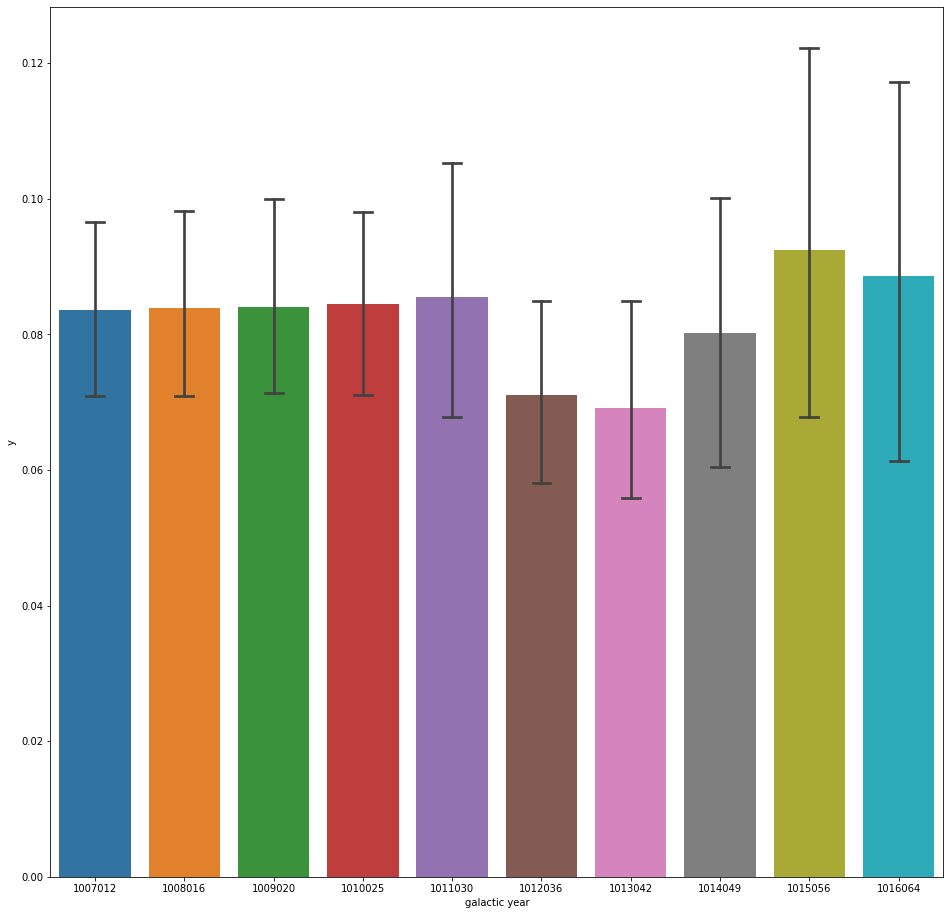

In [ ]:
good_m_y = pd.DataFrame({'galactic year': [1007012, 1008016, 1009020, 1010025, 1011030, 1012036, 1013042, 1014049, 1015056, 1016064], 
                         'y': [0.082435432, 0.082435432, 0.082435432, 0.082435432, 0.082617664, 0.082617664, 0.082617664, 0.082617664, 0.082617664, 0.082762643]})
import seaborn as sns
plt.figure(figsize=(16, 16))
sns.barplot(data=t_df, x='galactic year', y='y', capsize=.2)

In [ ]:
for i in range(0, good_m_y.shape[0] - 1):
    df_df = df.loc[df['galactic year'] == good_m_y.iloc[i, 0], 'y']
    prov_prov = t_df.loc[t_df['galactic year'] == good_m_y.iloc[i, 0], 'y']
    s_train = df_df.shape[0]
    s_prov = prov_prov.shape[0]
    df_mean = df_df.mean()
    prov_mean = prov_prov.mean()
    x = (good_m_y.iloc[i, 1] * (s_train + s_prov) - df_mean * s_train) / s_prov
    print(df_mean, prov_mean, x)
    t_df.loc[t_df['galactic year'] == good_m_y.iloc[i, 0], 'y'] = \
    t_df.loc[t_df['galactic year'] == good_m_y.iloc[i, 0], 'y'] / prov_mean * x

0.08133541447851508 0.0835887699143737 0.08353544952148492
0.08137869623860575 0.0838360061792267 0.08349216776139425
0.08138142128691091 0.0841033558112292 0.08348944271308908
0.08133078363096642 0.08443737068205193 0.08354008036903358
0.0800623392445083 0.0855084848827143 0.08517298875549167
0.09491656644141679 0.07113197584658207 0.07018057164351112
0.09800464379584507 0.06908319305506223 0.06723068420415491
0.08733208588196192 0.08024666564472342 0.07795621315041965
0.08085661952048549 0.09243893891150465 0.0843787084795145


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
prov_prov = t_df.loc[t_df['galactic year'] == 1016064, 'y']
prov_mean = prov_prov.mean()
t_df.loc[t_df['galactic year'] == 1016064, 'y'] = \
t_df.loc[t_df['galactic year'] == 1016064, 'y'] / prov_mean * good_m_y.iloc[-1, 1]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


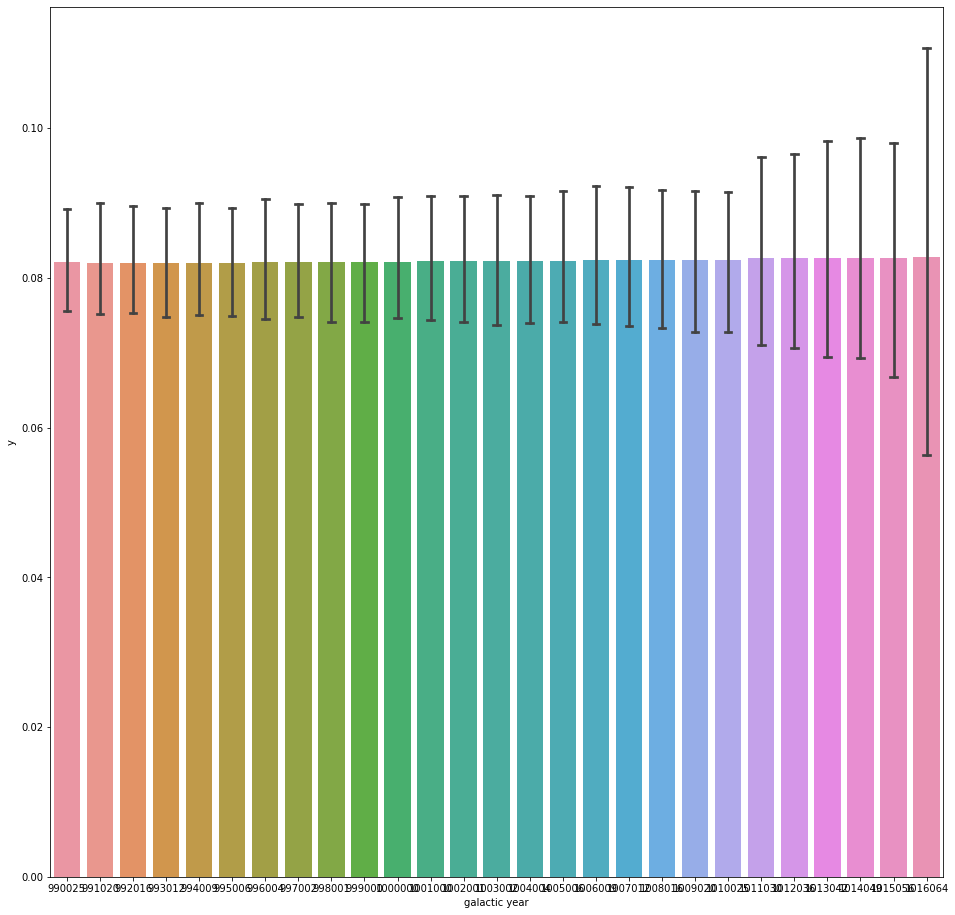

In [ ]:
dft_after2 = t_df.append(df, sort=False).reset_index(drop=True)
plt.figure(figsize=(16, 16))
sns.barplot(data=dft_after2, x='galactic year', y='y', capsize=.2)


our_best_y=t_df['y'] 

In [ ]:
our_best_y.to_csv('our_best_y_corrected.csv', index=False)  #this is our best Y predicted for the task 1 ( final prediction )

## `*this is the end of the first task , you can find Task 2 in the next notebook 'OptimizationTask' *`


---

